<a href="https://colab.research.google.com/github/karsarobert/DeepLearning2024/blob/main/04/PTE_DL4_ENG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning exercise


## Exercise 4: underfitting, overfitting
### 25 September 2024.

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Underfitting, overfitting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/overfit_and_underfit"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

As always, the code in the example uses the `tf.keras` API, which you can learn more about in TensorFlow [Keras guide](https://www.tensorflow.org/guide/keras).

It is important to learn how to handle overfitting. While it is often possible to achieve high accuracy on the *test set*, we really want to develop models that generalize well to the *test set* (or to data that has not yet been seen).

The opposite of overfitting is *underfitting*. Underfitting occurs when there is room for improvement in the training data. This can happen for a number of reasons: If the model is not strong enough, over-regularised, or simply not trained long enough. It means that the network has not learned the relevant patterns in the training data.

However, if it is trained for too long, the model starts to overfit and learns patterns from the training data that cannot be generalised to the test data. We need to find a balance. A useful skill is understanding how to train over an appropriate number of epochs, as we will explore below.

The best way to prevent overfitting is to use more complete training data. The data set should cover the full range of inputs that the model is expected to handle. Additional data should only be useful if they cover new and interesting cases.

A model trained on more complete data will naturally generalise better. If this is no longer possible, the next best option is to use techniques such as regularisation. These limit the amount and type of information the model can store.  If a network can only afford to memorize a small number of samples, the optimization process forces it to focus on the most salient samples, which have a higher chance of good generalization.

In this booklet, we will examine several common regularization techniques and use them to improve a classification model.



## Setup

Before we start, let's import the necessary packages:

In [ ]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers


In [ ]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-5d1v38jp
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-5d1v38jp
  Resolved https://github.com/tensorflow/docs to commit 98fa05949ba64f95c4df6565ea915a002a240289
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.7.15.51478-py3-none-any.whl size=182586 sha256=34e4e349a6d7d9a5c55cd4f0c90f10d6fca0925952142c5f1e4e005788cc1ce6
  Stored in directory: /tmp/pip-ephem-wheel-cache-7udapow6/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile


In [ ]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## The Higgs Dataset

The purpose of this tutorial is not particle physics, so let's not go into the details of the dataset. It contains 11&#x202F;000&#x202F;000 examples, each with 28 features and a binary class label.

In [ ]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816407858/2816407858 ━━━━━━━━━━━━━━━━━━━━ 125s 0us/step


In [ ]:
FEATURES = 28

The class tf.data.experimental.CsvDataset can be used to read csv records directly from a gzip file without an intermediate decompression step.

In [ ]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

This csv reader class returns a list of scalars for each record. The following function wraps the list of scalars in a (feature_vector, label) pair.

In [ ]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

TensorFlow is most efficient when working with large data sets.

So instead of repacking each row one by one, create a new dataset that takes 10,000 example batches, apply the pack_row function to each batch, and then repartition the batches into individual records:

In [ ]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


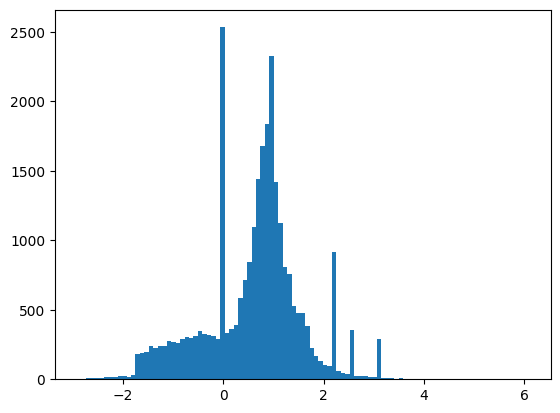

In [ ]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

To keep this tutorial relatively short, use only the first 1000 samples for validation and the next 10 000 samples for training:

In [ ]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

The Dataset.skip and Dataset.take methods make this easier.

At the same time, use the Dataset.cache method so that the loader does not have to re-read the data from the file at each epoch:

In [ ]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [ ]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

These datasets return specific examples. Use the `.batch` method to create batches of the appropriate size for training. Also, before batching, don't forget the `.shuffle` and `.repeat` operation stacks.

In [ ]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## Demonstrate overfitting
Demonstrate overfitting
The simplest way to prevent overfitting is to start with a small model: a model with a small number of learnable parameters (defined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the "capacity" of the model.

Intuitively, a model with more parameters will have a higher "memorization capacity" and will therefore be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping that has no generalization power, but that would be useless when making predictions on previously unseen data.

Always bear this in mind: deep learning models tend to fit training data well, but the real challenge is generalisation, not fit.

On the other hand, if the network has limited capacity, it will not be able to learn the mapping as easily. To minimize loss, it needs to learn compressed representations that have higher predictive power. However, if you make your model too small, it will have difficulty fitting the training data. You have to balance between "too much capacity" and "not enough capacity".

Unfortunately, there is no magic formula to determine the right size or architecture of your model (in terms of the number of layers or the right size of each layer). You need to experiment with different architectures.

To find the right model size, it's best to start with relatively few layers and parameters, then start increasing the size of the layers or adding new layers until you see diminishing returns on validation loss.

Start with a simple model using only layers.Dense as a base, then create larger versions and compare them.

### Tanítás

Many models learn better if they gradually reduce the learning rate as they learn. You can use `optimizers.schedules` to reduce the learning rate over time:

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

The above code sets a `schedules.InverseTimeDecay`, which hyperbolically reduces the learning rate to 1/2 of the base rate at 1000 epochs, 1/3 of the base rate at 2000 epochs, and so on.

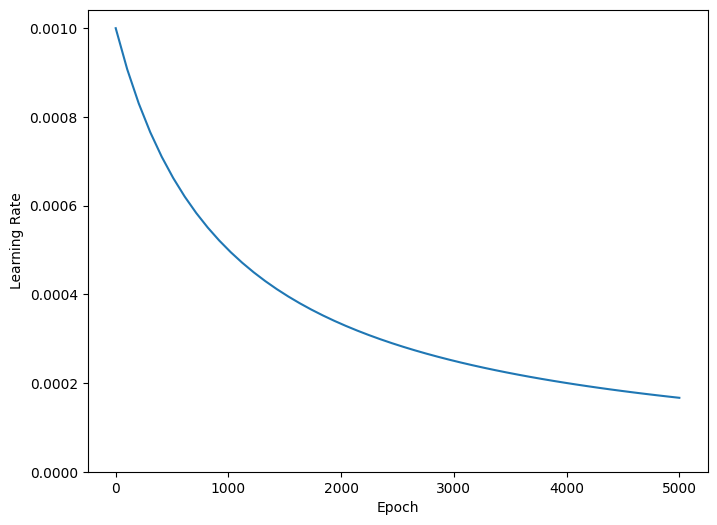

In [ ]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


In [ ]:
step

array([     0.        ,   2040.81632653,   4081.63265306,   6122.44897959,
         8163.26530612,  10204.08163265,  12244.89795918,  14285.71428571,
        16326.53061224,  18367.34693878,  20408.16326531,  22448.97959184,
        24489.79591837,  26530.6122449 ,  28571.42857143,  30612.24489796,
        32653.06122449,  34693.87755102,  36734.69387755,  38775.51020408,
        40816.32653061,  42857.14285714,  44897.95918367,  46938.7755102 ,
        48979.59183673,  51020.40816327,  53061.2244898 ,  55102.04081633,
        57142.85714286,  59183.67346939,  61224.48979592,  63265.30612245,
        65306.12244898,  67346.93877551,  69387.75510204,  71428.57142857,
        73469.3877551 ,  75510.20408163,  77551.02040816,  79591.83673469,
        81632.65306122,  83673.46938776,  85714.28571429,  87755.10204082,
        89795.91836735,  91836.73469388,  93877.55102041,  95918.36734694,
        97959.18367347, 100000.        ])

In this tutorial, all models use the same training configuration. So set them up in a reusable way, starting with the list of callbacks.

The training in this tutorial runs through many short periods. To reduce the logging noise, use `tfdocs.EpochDots`, which simply prints a `.` for each epoch, and the full set of metrics per 100 epochs.

Then set `callbacks.EarlyStopping` to avoid long and unnecessary training times. Note that this callback is set to monitor `val_binary_crossentropy`, not `val_loss`. This difference will be important later.

We can use `callbacks.TensorBoard` to generate TensorBoard logs for training.


In [ ]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

Likewise, all models will use the same "Model.compile" and "Model.fit" options:

In [ ]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

### Tiny model

Start by training a  tiny model:

In [ ]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
size_histories = {}

In [ ]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │             464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch: 0, accuracy:0.4800,  binary_crossentropy:0.7761,  loss:0.7761,  val_accuracy:0.4950,  val_binary_crossentropy:0.7477,  val_loss:0.7477,  
....................................................................................................
Epoch: 100, accuracy:0.6018,  binary_crossentropy:0.6243,  loss:0.6243,  val_accuracy:0.6000,  val_binary_crossentropy:0.6237,  val_loss:0.6237,  
....................................................................................................
Epoch: 200, accuracy:0.6280,  binary_crossentropy:0.6115,  loss:0.6115,  val_accuracy:0.6040,  val_binary_crossentropy:0.6144,  val_loss:0.6144,  
....................................................................................................
Epoch: 300, accuracy:0.6423,  binary_crossentropy:0.6013,  loss:0.6013,  val_accuracy:0.6070,  val_binary_crossentropy:0.6040,  val_loss:0.6040,  
....................................................................................................
Epoch: 40

Now check how the model has performed:

(0.5, 0.7)

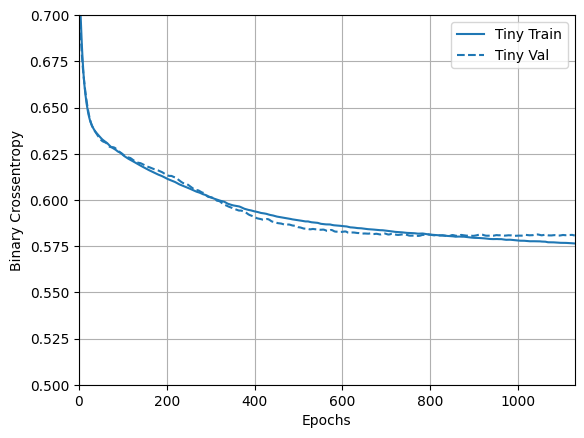

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

### Small model

To see if you can beat the performance of a small model, gradually train some larger models.

Try two hidden layers with 16 units each:

In [ ]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [ ]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 16)                  │             464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 753 (2.94 KB)

 Trainable params: 753 (2.94 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4794,  binary_crossentropy:0.7446,  loss:0.7446,  val_accuracy:0.4800,  val_binary_crossentropy:0.7140,  val_loss:0.7140,  
....................................................................................................
Epoch: 100, accuracy:0.6221,  binary_crossentropy:0.6159,  loss:0.6159,  val_accuracy:0.6040,  val_binary_crossentropy:0.6179,  val_loss:0.6179,  
....................................................................................................
Epoch: 200, accuracy:0.6582,  binary_crossentropy:0.5936,  loss:0.5936,  val_accuracy:0.6370,  val_binary_crossentropy:0.5979,  val_loss:0.5979,  
....................................................................................................
Epoch: 300, accuracy:0.6770,  binary_crossentropy:0.5798,  loss:0.5798,  val_accuracy:0.6580,  val_binary_crossentropy:0.5899,  val_loss:0.5899,  
....................................................................................................
Epoch: 40

### Medium model

Now try 3 hidden layers with 64 units each:

In [ ]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

And train the model with the same data:

In [ ]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 64)                  │           1,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,241 (40.00 KB)

 Trainable params: 10,241 (40.00 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4986,  binary_crossentropy:0.7040,  loss:0.7040,  val_accuracy:0.5080,  val_binary_crossentropy:0.6836,  val_loss:0.6836,  
....................................................................................................
Epoch: 100, accuracy:0.7059,  binary_crossentropy:0.5350,  loss:0.5350,  val_accuracy:0.6450,  val_binary_crossentropy:0.5998,  val_loss:0.5998,  
....................................................................................................
Epoch: 200, accuracy:0.7769,  binary_crossentropy:0.4416,  loss:0.4416,  val_accuracy:0.6420,  val_binary_crossentropy:0.6779,  val_loss:0.6779,  
................................................................................

### Large model

For practice, you can create an even larger model and see how quickly it starts to overfit.  Then add to this benchmark a network with much more capacity, much more than the problem would warrant:

In [ ]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

And train the model with the same data:

In [ ]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 512)                 │          14,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5009,  binary_crossentropy:0.8198,  loss:0.8198,  val_accuracy:0.4690,  val_binary_crossentropy:0.7009,  val_loss:0.7009,  
....................................................................................................
Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0024,  loss:0.0024,  val_accuracy:0.6380,  val_binary_crossentropy:1.8917,  val_loss:1.8917,  
....................................................................................................
Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0001,  loss:0.0001,  val_accuracy:0.6440,  val_binary_crossentropy:2.6122,  val_loss:2.6122,  
...........................

### Representation of training and validation losses

Solid lines indicate training loss and dashed lines indicate validation loss (remember: lower validation loss indicates a better model).

Although the structure of a larger model provides more performance, if this performance is not constrained in some way, it can easily overfit the training set.

In this example, typically only the "Tiny" model manages to avoid overfitting completely, and all of the larger models overfit the data faster. In the case of the ``Large'' model, this is so severe that we have to switch to a logarithmic scale on the graph to really see what is happening.

This becomes obvious when plotting and comparing validation metrics with training metrics.

* It is normal to have a slight difference.
* If both metrics are moving in the same direction, then everything is fine.
* If the validation metric is stagnating while the training metric is steadily improving, you are probably close to overfitting.
* If the validation metric is moving in the wrong direction, the model is clearly overfitting.

Text(0.5, 0, 'Epochs [Log Scale]')

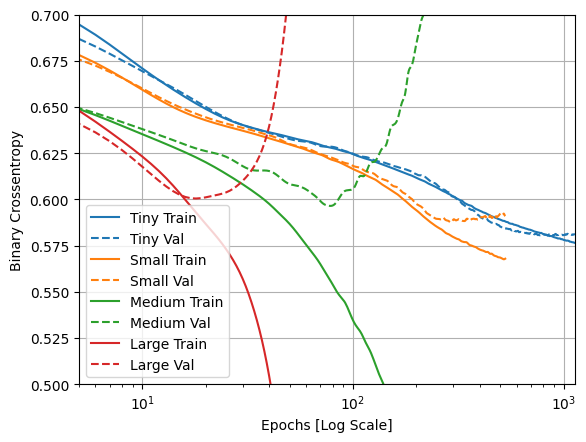

In [ ]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

Note: All the above training runs used the `callbacks.EarlyStopping` to end the training once it was clear the model was not making progress.

## Strategies to prevent overfitting

Before we go into the content of this section, let us copy the training logs of the ``Tiny'' model above to use as a basis for comparison.

In [ ]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmp4i8spug7/tensorboard_logs/regularizers/Tiny')

In [ ]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### Regularisation of weight parameters


You may be familiar with Occam's razor: if two explanations are given, the simplest explanation is most likely to be the correct one, i.e. the one that makes the fewest assumptions. This also applies to the models learned by neural networks: given certain training data and a network architecture, multiple sets of weights (multiple models) can explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model in which the distribution of parameter values has a smaller entropy (or a model that contains fewer parameters overall, as we saw in the section above). A common way to mitigate overfitting is therefore to limit the complexity of the network by constraining the weights to only small values, which makes the distribution of weight values more "regular". This is called "weight control" and is done by adding to the loss function of the network a cost associated with the existence of large weights. This cost can be of two types:

* [L1 regularisation](https://developers.google.com/machine-learning/glossary/#L1_regularization), where the added cost is proportional to the absolute value of the coefficients of the weights (i.e. the so-called "L1 norm" of the weights).

* [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization), where the added cost is proportional to the square of the coefficients of the weights (i.e. the "L2 norm" of the weights squared). L2 regularization is also called weight reduction in the context of neural networks. Don't let the different name confuse you: weight reduction is mathematically exactly the same as L2 regularisation.

L1 regularization shifts weights exactly towards zero, which encourages a sparse model. The L2 regularization will penalize the parameters of the weights without making them sparse, since the penalty goes to zero for small weights - one of the reasons why L2 is more prevalent.

In `tf.keras`, weight regularisation can be added to layers by passing weight regularisation instances as keyword arguments. Let us now add L2 weight regularization.


In [ ]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                     │ (None, 512)                 │          14,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5110,  binary_crossentropy:0.8254,  loss:2.3508,  val_accuracy:0.4650,  val_binary_crossentropy:0.7015,  val_loss:2.1508,  
..

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


..................................................................................................
Epoch: 100, accuracy:0.6517,  binary_crossentropy:0.5950,  loss:0.6191,  val_accuracy:0.6220,  val_binary_crossentropy:0.5976,  val_loss:0.6217,  
....................................................................................................
Epoch: 200, accuracy:0.6744,  binary_crossentropy:0.5835,  loss:0.6064,  val_accuracy:0.6950,  val_binary_crossentropy:0.5840,  val_loss:0.6072,  
....................................................................................................
Epoch: 300, accuracy:0.6879,  binary_crossentropy:0.5730,  loss:0.5952,  val_accuracy:0.6570,  val_binary_crossentropy:0.5827,  val_loss:0.6048,  
...............................................................................................

The `l2(0.001)` means that each coefficient of the weight matrix of the layer `0.001 * weight_coefficient**2` is added to the total **loss** of the network.

Therefore, we observe directly the value of `binary_crossentropy`. Because it does not have this regularization component mixed in.

So the same ``Large`` model with an `L2` regularization penalty performs much better:

(0.5, 0.7)

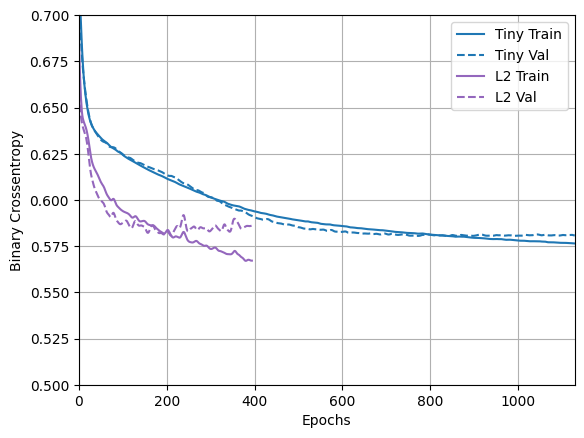

In [ ]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

As can be seen, the "L2" regularised model is much more competitive than the "Tiny" model. This ``L2'' model is also much more resistant to overfitting than the underlying ``Large'' model, despite having the same number of parameters.

#### More information

Two important things to note about this type of regularisation.

**First:** if you are writing your own training loop, be sure to look at the regularization losses of the model.

In [ ]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

**Other times:** This implementation works by adding the weight penalties to the model loss and then applying a standard optimization procedure.

There is a second approach that instead runs the optimizer only on the raw loss, and then while applying the computed step, the optimizer also applies some weight penalty. This "Decoupled Weight Decay" is seen in optimizers such as `optimizers.FTRL` and `optimizers.AdamW`.

### Add dropout

Dropout is one of the most efficient and widely used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

The intuitive explanation of dropout is that since each node in the network cannot rely on the output of the others, each node must output features that are intrinsically useful.

The dropout applied to a layer consists of randomly "dropping out" (i.e., setting to zero) some of the output attributes of the layer during training. Suppose that a given layer normally returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying the dropout, this vector will contain some randomly distributed zero entries, e.g. [0, 0.5,
1.3, 0, 1.1].

The "dropout rate" is the fraction of features that will be reset to zero; it is usually set between 0.2 and 0.5. When testing, no units are dropped, but instead the layer outputs are reduced by a factor equal to the dropout rate to compensate for the fact that more units are active than at training.

In `tf.keras`, we can introduce dropout into the network through the Dropout layer, which is applied directly to the output of the layer.

Let's add two Dropout layers to our network to see how well they can reduce overfitting:

In [ ]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                     │ (None, 512)                 │          14,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5013,  binary_crossentropy:0.8078,  loss:0.8078,  val_accuracy:0.4610,  val_binary_crossentropy:0.7069,  val_loss:0.7069,  
....................................................................................................
Epoch: 100, accuracy:0.6553,  binary_crossentropy:0.5934,  loss:0.5934,  val_accuracy:0.6800,  val_binary_crossentropy:0.5736,  val_loss:0.5736,  
....................................................................................................
Epoch: 200, accuracy:0.6863,  binary_crossentropy:0.5626,  loss:0.5626,  val_accuracy:0.7040,  val_binary_crossentropy:0.5899,  val_loss:0.5899,  
....................................................................................................
Epoch: 300, accuracy:0.7232,  binary_crossentropy:0.5114,  loss:0.5114,  val_accuracy:0.6770,  val_binary_crossentropy:0.6051,  val_loss:0.6051,  
...............................................

(0.5, 0.7)

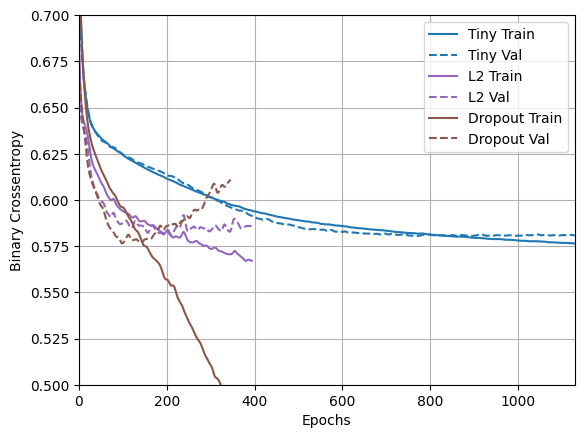

In [ ]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

It is clear from this diagram that both regularisation approaches improve the behaviour of the "big" model. But it still does not beat the basic "Tiny" model.

Let's try both together next time and see if it performs better.

### Combined L2 + dropout

In [ ]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 512)                 │          14,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5048,  binary_crossentropy:0.8119,  loss:0.9702,  val_accuracy:0.5190,  val_binary_crossentropy:0.6758,  val_loss:0.8334,  
....................................................................................................
Epoch: 100, accuracy:0.6492,  binary_crossentropy:0.6066,  loss:0.6372,  val_accuracy:0.6530,  val_binary_crossentropy:0.5835,  val_loss:0.6139,  
....................................................................................................
Epoch: 200, accuracy:0.6571,  binary_crossentropy:0.5907,  loss:0.6160,  val_accuracy:0.6810,  val_binary_crossentropy:0.5732,  val_loss:0.5985,  
....................................................................................................
Epoch: 300, accuracy:0.6656,  binary_crossentropy:0.5816,  loss:0.6098,  val_accuracy:0.6820,  val_binary_crossentropy:0.5643,  val_loss:0.5927,  
....................................................................................................
Epoch: 40

(0.5, 0.7)

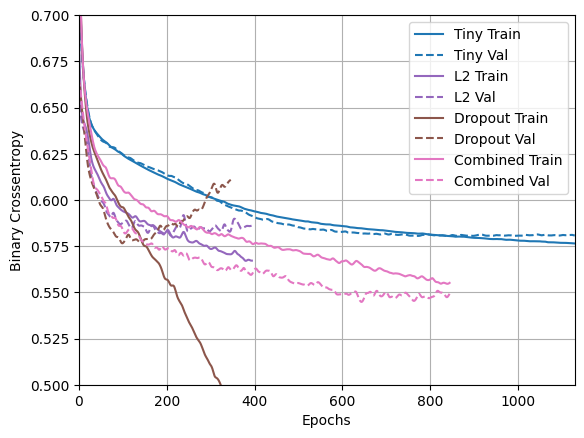

In [ ]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

This model with "combined" regularisation is obviously the best so far.

## Conclusion

In summary, here are the most common ways to prevent overfitting in neural networks:

* Obtain more training data.
* Reduce network capacity.
* Add weight control.
* Add outage.

Add more weight loss:

* data expansion
* batch normalization

Remember that each of these methods can help on their own, but often combining them can be even more effective.